In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

from torch.utils.data import DataLoader
from models import LeNet, StoLeNet
from utils import compute_accuracy, compute_ece_loss

In [2]:

# setup device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [3]:
device

device(type='cuda')

In [4]:
# prepare data
data_dir = "./data"
fig_dir = "./figs"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=False)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=False)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
# ===================================================== #
# ========= train a deterministic model =============== #
# ===================================================== #

num_epochs = 10
base_model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.002, momentum=0.9)

loss_list, acc_list, ece_list = [[] for _ in range(3)]
for epoch in range(num_epochs):
    base_model.train()
    batch_loss = []
    for img, label in trainloader:
        img, label = img.to(device), label.to(device)
        pred = base_model(img)
        loss = criterion(pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        
    avg_loss = sum(batch_loss)/len(batch_loss)
    base_acc = compute_accuracy(base_model, testloader, device=device)
    base_ece = compute_ece_loss(base_model, testloader, device=device)
    print("Base Model Epoch {} Avg Loss {:.4f} Acc {:.4f} ECE {:.4f}".format(epoch, avg_loss, base_acc, base_ece))
    loss_list.append(avg_loss)
    acc_list.append(base_acc)
    ece_list.append(base_ece)

Base Model Epoch 0 Avg Loss 1.4961 Acc 0.6971 ECE 0.0297
Base Model Epoch 1 Avg Loss 0.7110 Acc 0.7461 ECE 0.0317
Base Model Epoch 2 Avg Loss 0.6063 Acc 0.7836 ECE 0.0133
Base Model Epoch 3 Avg Loss 0.5472 Acc 0.7953 ECE 0.0182
Base Model Epoch 4 Avg Loss 0.5002 Acc 0.8146 ECE 0.0183
Base Model Epoch 5 Avg Loss 0.4690 Acc 0.8243 ECE 0.0214
Base Model Epoch 6 Avg Loss 0.4427 Acc 0.8303 ECE 0.0113
Base Model Epoch 7 Avg Loss 0.4216 Acc 0.8390 ECE 0.0102
Base Model Epoch 8 Avg Loss 0.4012 Acc 0.8346 ECE 0.0104
Base Model Epoch 9 Avg Loss 0.3901 Acc 0.8503 ECE 0.0101


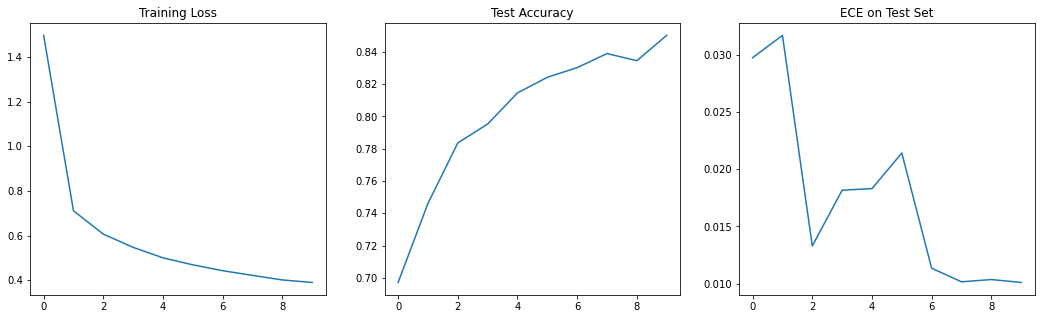

In [6]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
plt.plot(loss_list)
plt.title("Training Loss")
plt.subplot(1,3,2)
plt.plot(acc_list)
plt.title("Test Accuracy")
plt.subplot(1,3,3)
plt.plot(ece_list)
plt.title("ECE on Test Set")
plt.show()
fig.tight_layout()
fig.savefig(fig_dir + "/" + "deterministic lenet.jpg")

In [7]:
# ===================================================== #
# == migrate from base model, finetune and train flow = #
# ===================================================== #

sto_model_cfg = [
            ("normal", {"loc":1.0, "scale":0.5},  # the name of base distribution and parameters for that distribution
                [("affine", 1, {"learnable":True}), # the first stack of flows (type, depth, params)
                ("planar2d", 6, {"init_sigma":0.01})] # the second stack of flows (type, depth, params)
            ),
            (
                "normal", {"loc":1.0, "scale":0.5}, 
                [("affine", 1), 
                 ("planar", 6)]
            )
            ]
sto_model = StoLeNet(sto_cfg=sto_model_cfg).to(device)
sto_model.migrate_from_det_model(base_model)
det_params, sto_params = sto_model.det_and_sto_params()
optimizer = optim.Adam([
                {'params': det_params, 'lr': 2e-4},
                {'params': sto_params, 'lr': 2e-3}
            ])

In [8]:
num_epochs = 30
loss_list, ll_list, kl_list, acc_list, ece_list = [[] for _ in range(5)]
for epoch in range(num_epochs):
    sto_model.train()
    batch_loss, batch_ll, batch_kl = [[] for _ in range(3)]
    for img, label in trainloader:
        img, label = img.to(device), label.to(device)
        pred = sto_model(img)
        log_likelihood, kl = sto_model.calc_loss(pred, label)
        loss = -log_likelihood + kl / len(trainloader.dataset)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        batch_ll.append(log_likelihood.item()) 
        batch_kl.append(kl.item()/ len(trainloader.dataset))
    avg = lambda l: sum(l)/len(l)
    avg_loss, avg_ll, avg_kl = avg(batch_loss), avg(batch_ll), avg(batch_kl)
    sto_acc = compute_accuracy(sto_model, testloader)
    sto_ece = compute_ece_loss(sto_model, testloader)
    print("Sto Model Epoch {} Avg Loss {:.4f} Likelihood {:.4f} KL {:.4f} Acc {:.4f} ECE {:.4f}".format(
                        epoch, avg_loss, avg_ll, avg_kl,sto_acc, sto_ece))
    loss_list.append(avg_loss)
    ll_list.append(avg_ll)
    kl_list.append(avg_kl)
    acc_list.append(sto_acc)
    ece_list.append(sto_ece)

Sto Model Epoch 0 Avg Loss 0.4167 Likelihood -0.4160 KL 0.0007 Acc 0.8587 ECE 0.0218
Sto Model Epoch 1 Avg Loss 0.3707 Likelihood -0.3683 KL 0.0024 Acc 0.8582 ECE 0.0139
Sto Model Epoch 2 Avg Loss 0.3537 Likelihood -0.3505 KL 0.0032 Acc 0.8695 ECE 0.0185
Sto Model Epoch 3 Avg Loss 0.3401 Likelihood -0.3366 KL 0.0035 Acc 0.8729 ECE 0.0086
Sto Model Epoch 4 Avg Loss 0.3280 Likelihood -0.3243 KL 0.0037 Acc 0.8745 ECE 0.0078
Sto Model Epoch 5 Avg Loss 0.3157 Likelihood -0.3120 KL 0.0037 Acc 0.8701 ECE 0.0073
Sto Model Epoch 6 Avg Loss 0.3081 Likelihood -0.3043 KL 0.0038 Acc 0.8742 ECE 0.0089
Sto Model Epoch 7 Avg Loss 0.2988 Likelihood -0.2949 KL 0.0038 Acc 0.8765 ECE 0.0132
Sto Model Epoch 8 Avg Loss 0.2912 Likelihood -0.2873 KL 0.0039 Acc 0.8807 ECE 0.0105
Sto Model Epoch 9 Avg Loss 0.2841 Likelihood -0.2803 KL 0.0038 Acc 0.8835 ECE 0.0073
Sto Model Epoch 10 Avg Loss 0.2777 Likelihood -0.2739 KL 0.0038 Acc 0.8774 ECE 0.0114
Sto Model Epoch 11 Avg Loss 0.2701 Likelihood -0.2664 KL 0.0038 

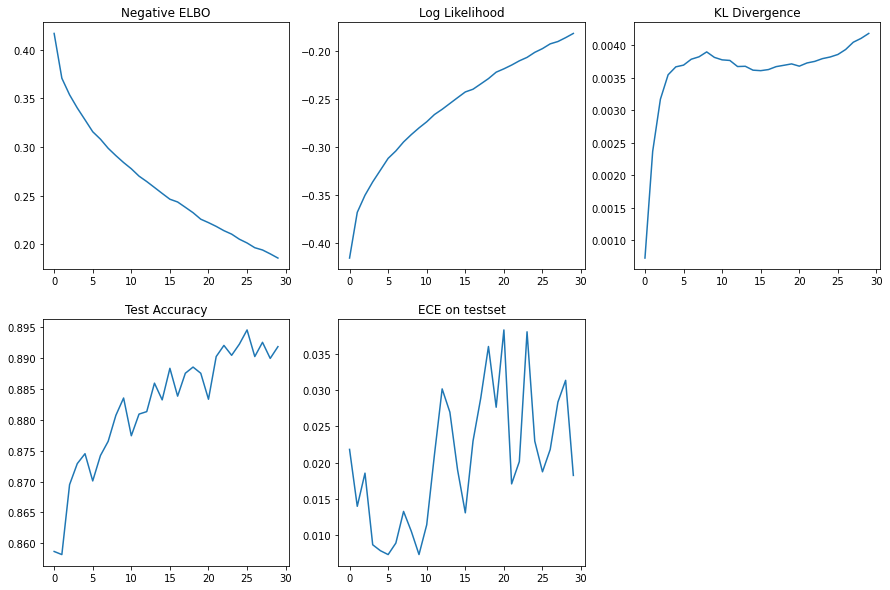

In [9]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(loss_list)
plt.title("Negative ELBO")
plt.subplot(2,3,2)
plt.plot(ll_list)
plt.title("Log Likelihood")
plt.subplot(2,3,3)
plt.plot(kl_list)
plt.title("KL Divergence")
plt.subplot(2,3,4)
plt.plot(acc_list)
plt.title("Test Accuracy")
plt.subplot(2,3,5)
plt.plot(ece_list)
plt.title("ECE on testset")
plt.show()
fig.tight_layout()
fig.savefig(fig_dir + "/" + "stochastic lenet.jpg")